In [1]:
import os
import sys
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy import signal, stats
from glob import glob
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

### Subjects

In [5]:
## Mice that have at least one recovery state ##
sub_dirs = {
    '546655': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\stim_test4_2020-10-23_10-38-37\experiment1\recording1',
    '551400': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551400\stim_test_2021-01-22_10-38-03\experiment1\recording1',
    '551399': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551399\stim_test_2021-01-28_13-35-01\experiment1\recording1',
    '551397': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\stim_test_2021-02-11_10-19-58\experiment1\recording1',
    '569062': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569062\stim_test_2021-02-18_10-57-30\experiment1\recording1',
    '569068': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569068\stim_test_2021-03-04_10-29-44\experiment1\recording1',
}

### Load experiments

In [6]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\stim_amp_analysis'

Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.


### Load eeg data and gather stim-evoked traces

In [7]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim

apply_mask = True
apply_car = True
apply_bpfilt = True

In [8]:
estim_traces = {}
sub_good_chs = {}
for mousei, expi in sub_exp.items():
    print(mousei)
    start = time.time()
    # load stim log
    stim_log, good_chs = expi.qualitycheck_trials_chs()
    amps_list = np.sort(stim_log.loc[stim_log.stim_type == 'biphasic', 'parameter'].unique())
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    
    # mask estim artifact
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    
    # get evoked traces
    estim_traces[mousei] = {}
    sub_good_chs[mousei] = {}
    for ampi in amps_list:
        events = get_stim_events(stim_log, 'biphasic', ampi, 0)
        if len(events) == 0:
#             print('{} \u03BCA: no good trials found'.format(str(ampi)))
            continue
#         print('{} \u03BCA: {:d} good trials'.format(str(ampi), len(events)))
        GOOD_CHS = good_chs['biphasic'][ampi][0]
        event_traces, event_ts = get_evoked_traces(
            datai,
            tsi,
            events,
            before_event,
            after_event,
            expi.ephys_params['EEG']['sample_rate']
        )
                
        # apply common avg
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                    
        # apply lowpass filter
        if apply_bpfilt:
            filtb, filta = signal.butter(3, np.array([0.5, 100])/(expi.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
        else:
            filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
           
        estim_traces[mousei][str(ampi)] = [event_ts, signal.filtfilt(filtb, filta, event_traces, axis=0)]
        sub_good_chs[mousei][str(ampi)] = GOOD_CHS
            
    del datai
    del tsi
    del stim_log

    end = time.time()
    print('Time: {:.2f} s'.format(end - start))
    print('')

546655
Time: 6.14 s

551400
Time: 9.50 s

551399
Time: 6.52 s

551397
Time: 9.21 s

569062
Time: 6.87 s

569068
Time: 5.40 s



### Plot traces for all amps

<IPython.core.display.Javascript object>


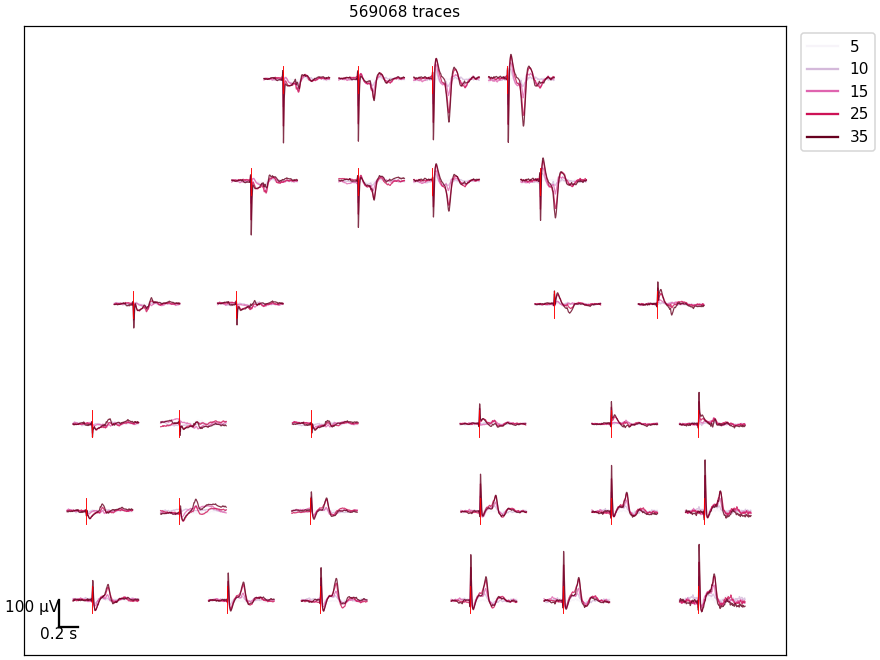

In [11]:
subject = '569068'
prex = .2 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8
ymult = 300

## line colors ##
colormap = plt.cm.PuRd # cool
ampcolors = [colormap(i) for i in np.linspace(0, 1, len(estim_traces[subject].keys()))]

fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
legend_entries = []
for (ampi, datai), ampcolori in zip(estim_traces[subject].items(), ampcolors):
    pinds = np.squeeze(np.argwhere((datai[0] >= -prex) & (datai[0] <= postx)))
    traces = np.mean(datai[1], axis=2)
    for chi in sub_good_chs[subject][ampi]:
#     for chi in eegchs:
        ax.plot(
            datai[0][pinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
            traces[pinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
            color=ampcolori,
            linewidth=0.8,
            alpha=0.8
        )
        if chi == 0:
            mx = datai[0][0] + EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.8
            my = EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult
    legend_entries.append(Line2D([0], [0], color=ampcolori, label=ampi))

for chi in eegchs:
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult), 0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult), 50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='r', linewidth=0.6)
    
x_len = .2 # x scale bar length in ms
y_len = 100 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

ax.set_title('{} traces'.format(subject))
ax.legend(handles=legend_entries, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE ###
# fig.savefig(os.path.join(plotsavedir, 'VEPs_traces_frontvscbref.png'), transparent=True)

### Calculate signal-to-noise ratio for each electrode

In [ ]:
subject = '569068'
amps_list = sorted(estim_traces[subject].keys(), key=int)
snrs = np.zeros
for ampi in amps_list:
    timex = estim_traces[subject][ampi][0]
    traces = np.mean(estim_traces[subject][ampi][1], axis=2)

In [ ]:
resp_power = np.mean(np.square(signal_svd[:,resp_ini_ix:resp_end_ix]), axis=1)
base_power = np.mean(np.square(signal_svd[:,base_ini_ix:base_end_ix]), axis=1)
snrs = np.sqrt(resp_power / base_power)

### Plot avg traces

<IPython.core.display.Javascript object>


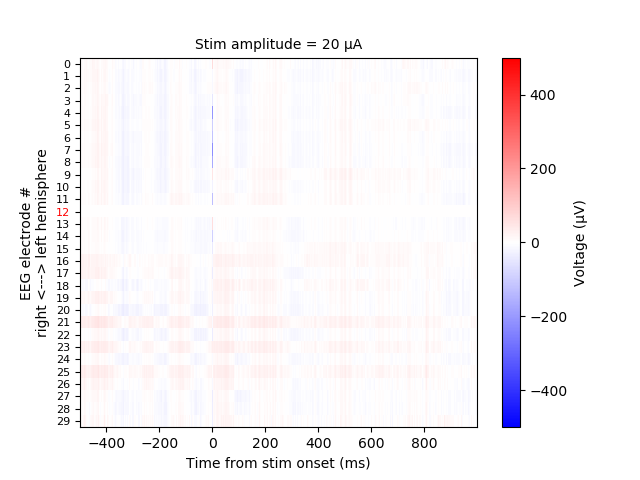

<IPython.core.display.Javascript object>


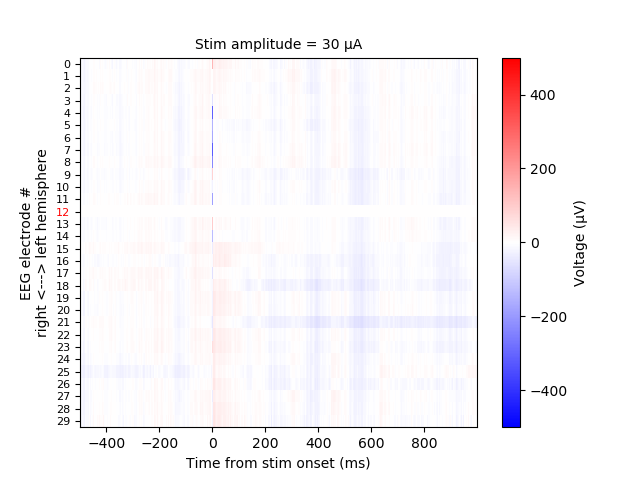

<IPython.core.display.Javascript object>


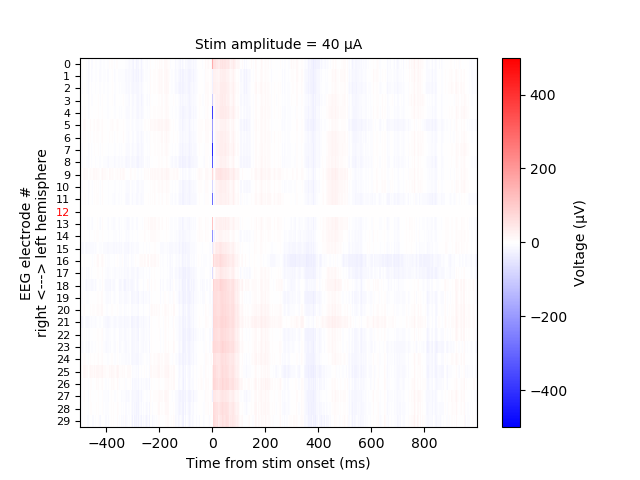

<IPython.core.display.Javascript object>


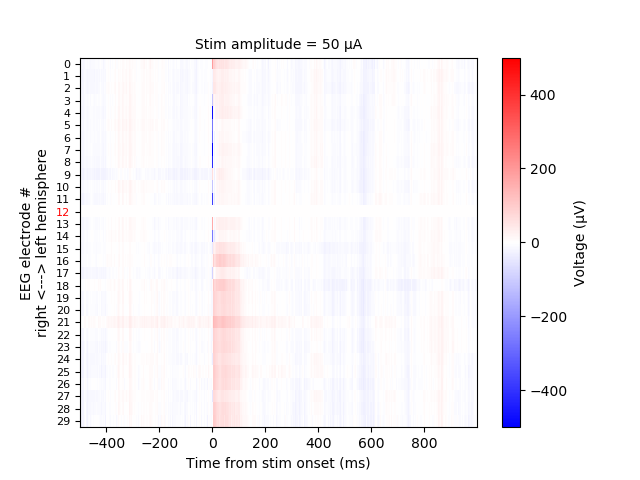

<IPython.core.display.Javascript object>


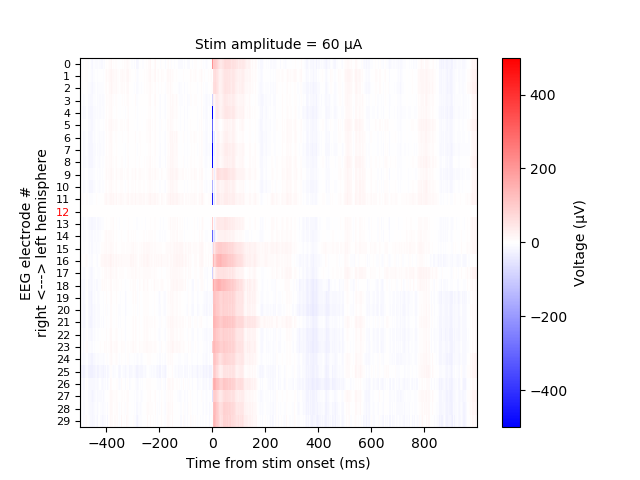

<IPython.core.display.Javascript object>


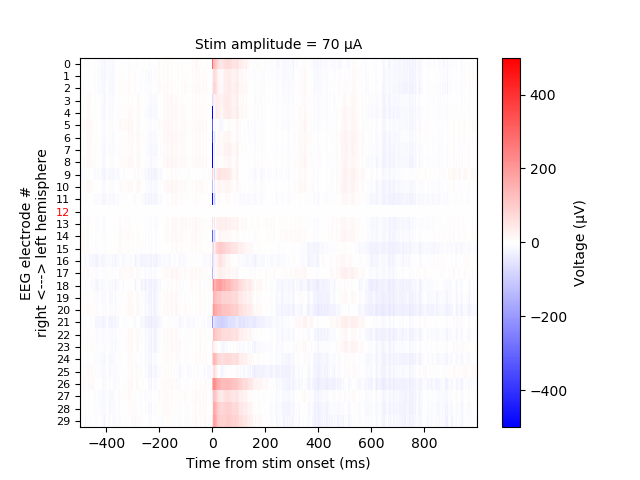

<IPython.core.display.Javascript object>


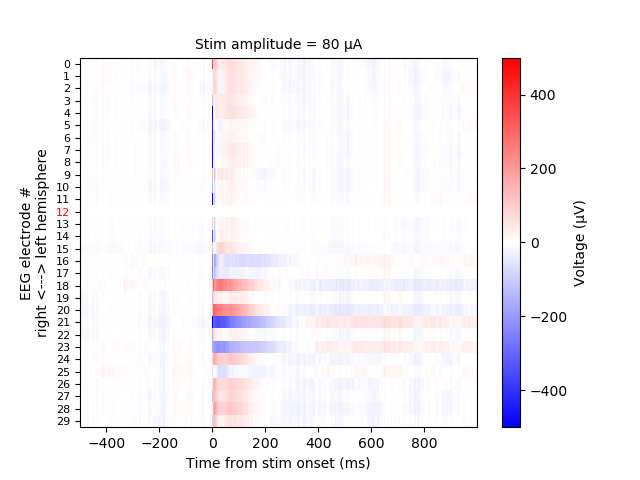

<IPython.core.display.Javascript object>


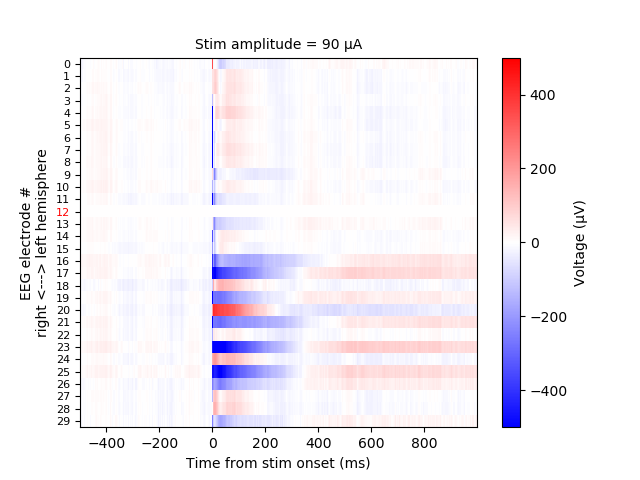

In [28]:
pick_mouse = '546657b'
pick_sweep = 0
set_vrange = 500
mask_bad_chs = True

for ampi in sub_stim_amps[pick_mouse]:
    
    plot_avgtraces = sub_avg_traces[pick_mouse][ampi][pick_sweep][:, realchs].T
    if mask_bad_chs:
        mask_traces = np.zeros((len(bad_chs[pick_mouse]), np.shape(plot_avgtraces)[1]))
        plot_avgtraces[bad_chs[pick_mouse],:] = mask_traces
    
    fig, ax = plt.subplots()
    avg_traces_plot = ax.imshow(plot_avgtraces,
                                cmap='bwr',
                                aspect='auto',
                                vmin=-set_vrange,
                                vmax=set_vrange,
                                extent=[event_ts[0], event_ts[-1], len(realchs), 0],
                               )
    ax.set_yticks(np.arange(len(realchs))+0.5)
    ax.set_yticklabels(realchs, fontsize=8)
    for ytick in ax.get_yticklabels():
        if int(ytick.get_text()) in bad_chs[pick_mouse]:
            ytick.set_color('r')
    ax.set_title('Stim amplitude = %d \u03BCA' % ampi)
    ax.set_xlabel('Time from stim onset (ms)')
    ax.set_ylabel('EEG electrode #\nright <---> left hemisphere')
    cbar = plt.colorbar(avg_traces_plot)
    cbar.set_label('Voltage (\u03BCV)')
    
    # Save plots?
#     plot_title = ('Ramp_avg_evoked_traces_%duA.png' % ampi)
#     plt.savefig(os.path.join(plotsavedir, plot_title), format='png')

### Get response durations

In [29]:
z_threshold = 3

mlabels = []
trace_duration_means = {}
trace_mean_durations = {}
all_ch_durations = []
for mousei, expi in sub_exp.items():
    tdms = []
    tmds = []
    for ampi in sub_stim_amps[mousei]:
        for sweepi in awake_sweeps[mousei]:
            event_zscore = sub_zscores[mousei][ampi][sweepi]
            # find duration of each trial, then average later
            trace_durs = np.sum(np.abs(event_zscore[event_ts>1.,:,:]) > z_threshold, axis=0) / expi.ephys_params['EEG']['sample_rate']
            # find average zscore, then find duration
            tracemean_dur = np.sum(np.abs(np.mean(event_zscore, axis=2)[event_ts>1.,:]) > z_threshold, axis=0) / expi.ephys_params['EEG']['sample_rate']
            ## make labels and array for box plot
#             mlabels.append(mousei+'_'+str(ampi)+'_'+str(sweepi))
            mlabels.append(str(ampi))
            all_ch_durations.append(trace_durs)
            tdms.append(np.mean(trace_durs, axis=1))
            tmds.append(tracemean_dur)
    trace_duration_means[mousei] = np.array(tdms)
    trace_mean_durations[mousei] = np.array(tmds)
print(np.shape(trace_duration_means[mousei]))

(8, 32)


In [25]:
print(np.shape(all_ch_durations[0]))

(32, 60)


<IPython.core.display.Javascript object>


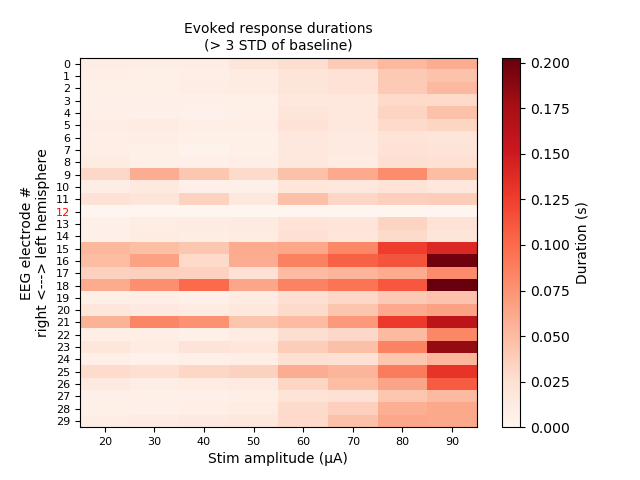

In [36]:
# calculated zscore for each ch/amp/trial, then found duration of responses > z_threshold, took mean across trials
pick_mouse = '546657a'
pick_sweep = 0
set_vrange = 0.3 # s
mask_bad_chs = True

plot_mean_dur = trace_duration_means[pick_mouse][:, realchs].T
if mask_bad_chs:
    mask_traces = np.zeros((len(bad_chs[pick_mouse]), np.shape(plot_mean_dur)[1]))
    plot_mean_dur[bad_chs[pick_mouse],:] = mask_traces

fig, ax = plt.subplots()
resp_dur = ax.imshow(plot_mean_dur,
                     cmap='Reds',
                     aspect='auto',
#                      vmin=0,
#                      vmax=set_vrange,
#                      norm=LogNorm(vmin=0.01, vmax=0.3),
                     interpolation='none',
                    )
ax.set_yticks(np.arange(len(realchs)))
ax.set_yticklabels(realchs, fontsize=8)
for ytick in ax.get_yticklabels():
    if int(ytick.get_text()) in bad_chs[pick_mouse]:
        ytick.set_color('r')
ax.set_xticks(np.arange(len(sub_stim_amps[pick_mouse])))
ax.set_xticklabels(sub_stim_amps[pick_mouse], fontsize=8)
ax.set_title('Evoked response durations\n(> %d STD of baseline)' % z_threshold)
ax.set_xlabel('Stim amplitude (\u03BCA)')
ax.set_ylabel('EEG electrode #\nright <---> left hemisphere')
cbar = plt.colorbar(resp_dur)
cbar.set_label('Duration (s)')

### Peak-to-peak voltage

In [33]:
windows = [(1, 5), (5, 20)] # time windows in ms (positive, negative peak, respectively)
mean_peak_mags = {}
all_peak_mags = {}
for mousei, expi in sub_exp.items():
    all_peak_mags[mousei] = []
    mean_peak_diffs = []
    for ampi in sub_stim_amps[mousei]:
        peak_diffs = []
        for sweepi in awake_sweeps[mousei]:
            ## get time inds
            first_inds = np.argwhere((sub_timex[mousei][ampi][sweepi] > windows[0][0]) & (sub_timex[mousei][ampi][sweepi] < windows[0][1])).flatten()
            second_inds = np.argwhere((sub_timex[mousei][ampi][sweepi] > windows[1][0]) & (sub_timex[mousei][ampi][sweepi] < windows[1][1])).flatten()
            ## find peaks
            first_peak = np.max(sub_traces[mousei][ampi][sweepi][first_inds,:,:], axis=0)
            second_peak = np.min(sub_traces[mousei][ampi][sweepi][second_inds,:,:], axis=0)
            ## append max - min
            peak_diffs.append(first_peak-second_peak)
            
        all_peak_mags[mousei].append(np.concatenate(peak_diffs, axis=0))
        mean_peak_diffs.append(np.mean(np.concatenate(peak_diffs, axis=0), axis=1))
    mean_peak_mags[mousei] = np.array(mean_peak_diffs)
    
# print(np.shape(mean_peak_mags['543396a']))

<IPython.core.display.Javascript object>


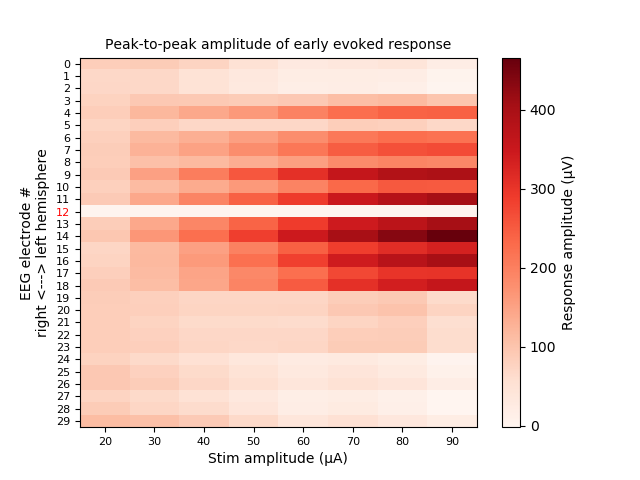

In [34]:
# calculated peak-to-peak for each ch/amp/trial, then found mean across trials
pick_mouse = '546657a'
# set_vrange = 0.15 # s
mask_bad_chs = True

plot_peak_mean = mean_peak_mags[pick_mouse][:, realchs].T
if mask_bad_chs:
    mask_traces = np.zeros((len(bad_chs[pick_mouse]), np.shape(plot_peak_mean)[1]))
    plot_peak_mean[bad_chs[pick_mouse],:] = mask_traces

fig, ax = plt.subplots()
peak_mean = ax.imshow(plot_peak_mean,
                     cmap='Reds',
                     aspect='auto',
#                      vmin=0,
#                      vmax=set_vrange,
#                      norm=LogNorm(vmin=0.01, vmax=0.3),
                     interpolation='none',
                    )
ax.set_yticks(np.arange(len(realchs)))
ax.set_yticklabels(realchs, fontsize=8)
for ytick in ax.get_yticklabels():
    if int(ytick.get_text()) in bad_chs[pick_mouse]:
        ytick.set_color('r')
ax.set_xticks(np.arange(len(sub_stim_amps[pick_mouse])))
ax.set_xticklabels(sub_stim_amps[pick_mouse], fontsize=8)
ax.set_title('Peak-to-peak amplitude of early evoked response')
ax.set_xlabel('Stim amplitude (\u03BCA)')
ax.set_ylabel('EEG electrode #\nright <---> left hemisphere')
cbar = plt.colorbar(peak_mean)
cbar.set_label('Response amplitude (\u03BCV)')

<IPython.core.display.Javascript object>


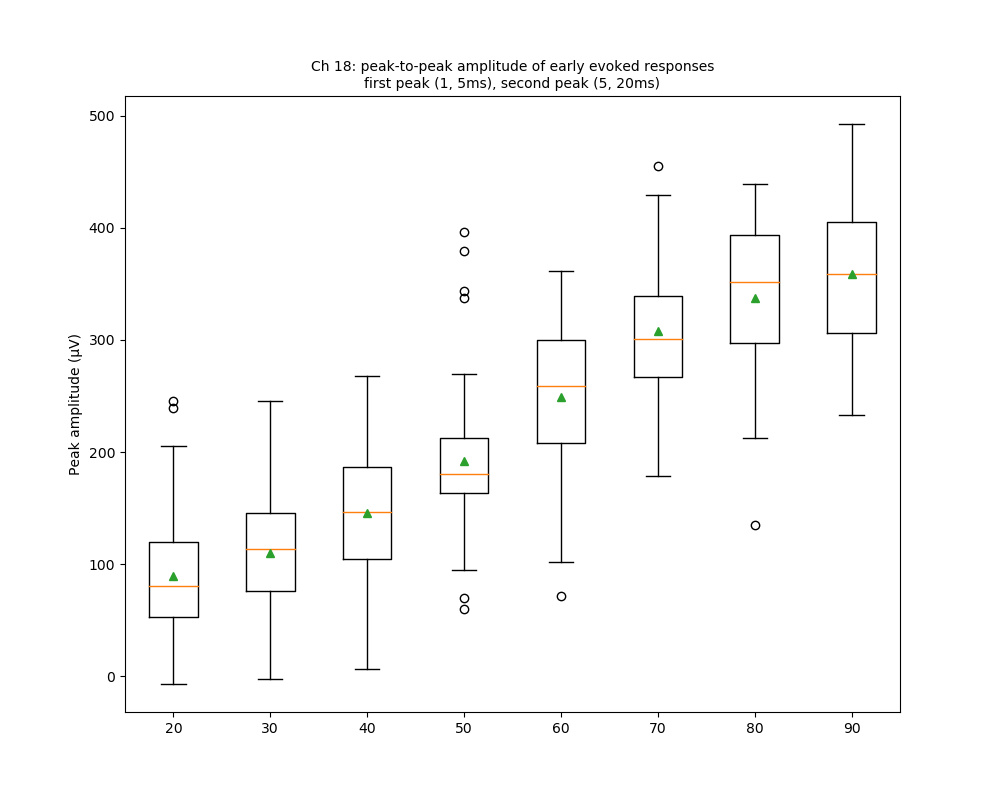

Text(0.5, 1.0, 'Ch 18: peak-to-peak amplitude of early evoked responses\nfirst peak (1, 5ms), second peak (5, 20ms)')

In [35]:
# makes boxplot for single ch, to see spread of peaks
plch = 18
pl_pks = [x[plch,:] for x in all_peak_mags[pick_mouse]]
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(pl_pks, showmeans=True, labels=sub_stim_amps[pick_mouse])
# plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
# ax.set_ylim([-0.005, 0.3])
ax.set_ylabel('Peak amplitude (\u03BCV)')
ax.set_title('Ch %d: peak-to-peak amplitude of early evoked responses\nfirst peak (%d, %dms), second peak (%d, %dms)' % (plch, windows[0][0], windows[0][1], windows[1][0], windows[1][1]))